Author: 黃榮晟
2022/10/06

### Importing the libraries

In [1]:
# Importing the libraries
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from util import get_dummies, detect_str_columns,model_testRF,results_summary_to_dataframe,plot_confusion_matrix,logistic_model,logistic_importance,logistic_conf

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, auc, accuracy_score,classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# ----設定繪圖-------
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import os
import platform

import plotly.tools as tls
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'browser'
from datetime import timedelta, datetime

In [2]:
# 若無法讀取，請在csv檔案前加上檔案路徑
df_original = pd.read_csv("winemag-data_first150k.csv")

In [3]:
# Check the first five rows.
df_original = df_original.rename(columns={"Unnamed: 0":"id"})
df_original.head(5)

,id,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


## Data Processing

In [4]:
# See the coulns type
df_original.dtypes

id               int64
country         object
description     object
designation     object
points           int64
price          float64
province        object
region_1        object
region_2        object
variety         object
winery          object
dtype: object

In [5]:
# Check the Null values in each columns.
# WE DO NOT NEED TO FILL THE VALUES.
# Beacuse the numbers don't have null values.
df_original.isnull().sum()

id                 0
country            5
description        0
designation    45735
points             0
price          13695
province           5
region_1       25060
region_2       89977
variety            0
winery             0
dtype: int64

In [6]:
# 不需要跑
# Fill in mean to the cloumns which have NULL values.
#df_original['price'].fillna(value = df_original.price.mean(), inplace = True)

### 探索性分析（EDA）
#### 敘述性統計 - 分析

In [7]:
# Price statistics number
df_original.price.describe()

count    137235.000000
mean         33.131482
std          36.322536
min           4.000000
25%          16.000000
50%          24.000000
75%          40.000000
max        2300.000000
Name: price, dtype: float64

In [8]:
len(df_original[df_original['price'] < 25])

69220

In [9]:
# Points statistics number
df_original.points.describe()

count    150930.000000
mean         87.888418
std           3.222392
min          80.000000
25%          86.000000
50%          88.000000
75%          90.000000
max         100.000000
Name: points, dtype: float64

<AxesSubplot:xlabel='points', ylabel='price'>

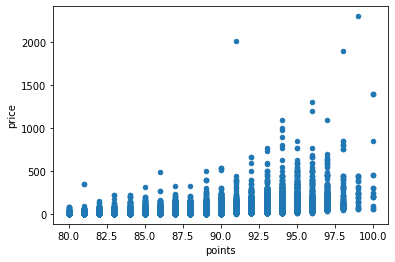

In [10]:
# Scatter plot
## Price and Points
df_original.plot.scatter(x='points', y='price')

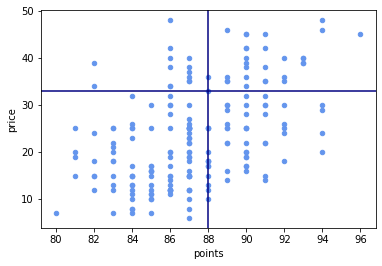

In [11]:
import matplotlib.ticker as mticker
# Scatter Chart for "Price" amd "Points"
df_original[df_original['price'] < 50].sample(200,random_state=10).plot.scatter(x='points', y='price', color= '#6495ED')

# Draw x = 100's Line
# 平均數（Mean's points
plt.axvline(x = 88, color = '#000080', label = 'axvline')

# 平均數（Mean's price
plt.axhline(y = 33, color = '#000080', label = 'axhline')

### Find Most common grape varieties in the wine

[The 10 Most Popular Types of Wine](https://learn.winecoolerdirect.com/popular-types-of-wine/)

In [84]:
df_count = df_original.groupby('variety', as_index = False).count()
#因為是Counts，所以是算出來是酒類的總數
df_count['counts'] = df_count['id']
df_count = df_count.loc[:,['variety', 'counts']]

common_wine = df_count.sort_values('counts', ascending= False)


,variety,counts
110,Chardonnay,14482
402,Pinot Noir,14291
70,Cabernet Sauvignon,12800
429,Red Blend,10062
51,Bordeaux-style Red Blend,7347
468,Sauvignon Blanc,6320
513,Syrah,5825
435,Riesling,5524
298,Merlot,5070
628,Zinfandel,3799


In [85]:
common_wine_top10 = common_wine.iloc[0:10,:]
common_wine_top10

,variety,counts
110,Chardonnay,14482
402,Pinot Noir,14291
70,Cabernet Sauvignon,12800
429,Red Blend,10062
51,Bordeaux-style Red Blend,7347
468,Sauvignon Blanc,6320
513,Syrah,5825
435,Riesling,5524
298,Merlot,5070
628,Zinfandel,3799


In [41]:
# %%
# barchart:長條圖
fig = px.bar(common_wine_top10,
             x = 'variety', y = 'counts',
             title='wine varity 長條圖' ,
             color = 'counts')
iplot(fig)
plot(fig , filename= 'wine_counts_top10.html')

'wine_counts_top10.html'

### Wine Variety 佔比
#### 80/20 Rule


In [86]:
# 計算「累計 COUNT 總數」
common_wine['cumsum_counts'] = common_wine['counts'].cumsum()

common_wine.head(6)

,variety,counts,cumsum_counts
110,Chardonnay,14482,14482
402,Pinot Noir,14291,28773
70,Cabernet Sauvignon,12800,41573
429,Red Blend,10062,51635
51,Bordeaux-style Red Blend,7347,58982
468,Sauvignon Blanc,6320,65302


In [87]:
# 計算「COUNT 總數」
total_counts = common_wine['counts'].sum()
print(total_counts)


150930


In [88]:
# 累積佔比
common_wine['Counts %'] = common_wine['cumsum_counts'] / total_counts

In [89]:
# < 80% 的累積佔比
common_wine80 = common_wine[ common_wine['Counts %'] <= 0.8 ] 

In [90]:
# %%
# 列印出來
common_wine80

,variety,counts,cumsum_counts,Counts %
110,Chardonnay,14482,14482,0.095952
402,Pinot Noir,14291,28773,0.190638
70,Cabernet Sauvignon,12800,41573,0.275446
429,Red Blend,10062,51635,0.342112
51,Bordeaux-style Red Blend,7347,58982,0.390790
468,Sauvignon Blanc,6320,65302,0.432664
513,Syrah,5825,71127,0.471258
435,Riesling,5524,76651,0.507858
298,Merlot,5070,81721,0.541450
628,Zinfandel,3799,85520,0.566620


In [93]:
# 80%的酒品佔據多少的市場。

contr_percent = len(common_wine80) / int(total_counts)
print( str(round( contr_percent*100 ,2 )) + '% of the variety dominate 80% of the wine market.' )


0.02% of the variety dominate 80% of the wine market.


In [94]:
## 畫圖
fig = px.bar(common_wine80,
             x = 'variety', 
             y = 'counts',
             title=' 80/20 Wine counts 排序長條圖' ,
             color = 'counts',
             hover_data = ['Counts %']
             )
plot(fig, filename= '8020.html')

'8020.html'

### TOP 5 Country

In [96]:
df_count_country = df_original.groupby('country', as_index = False).count()
df_count_country ['counts'] = df_count_country ['id'] 
#因為是Counts，所以是算出來是國家的總數
#df_count_country.head(10)

top_country_wine = df_count_country .loc[:,['country' , 'counts']]

top_country_wine = top_country_wine.sort_values('counts', ascending= False)
top_country_wine.head(5)

,country,counts
44,US,62397
22,Italy,23478
15,France,21098
40,Spain,8268
8,Chile,5816


In [97]:
# %%
# barchart:長條圖
fig = px.bar(top_country_wine,
             x = 'country', y = 'counts',
             title='Country barchart' ,
             color = 'counts')
iplot(fig)
plot(fig , filename= 'wine_country_top.html')

'wine_country_top.html'

#### Country 80/20

In [ ]:
country_counts = df_original.groupby("country").points.count().sort_values(ascending = False)
country_cumsum = country_counts.cumsum()
country_cumsum_percentage = country_cumsum / country_counts.sum()
country_cumsum_percentage[country_cumsum_percentage < .8]

In [98]:
# 計算「累計 COUNT 總數」
top_country_wine['cumsum_counts'] = top_country_wine['counts'].cumsum()

top_country_wine.head(6)

,country,counts,cumsum_counts
44,US,62397,62397
22,Italy,23478,85875
15,France,21098,106973
40,Spain,8268,115241
8,Chile,5816,121057
1,Argentina,5631,126688


In [100]:
# 計算「COUNT 總數」
total_counts = top_country_wine['counts'].sum()
print(total_counts)

150925


In [102]:
# Country 累積佔比
top_country_wine['Counts %'] = top_country_wine['cumsum_counts'] / total_counts

In [103]:
# Country < 80% 的累積佔比
top_country_wine80 = top_country_wine[ top_country_wine['Counts %'] <= 0.8 ] 

In [104]:
# Print it out
top_country_wine80

,country,counts,cumsum_counts,Counts %
44,US,62397,62397,0.413431
22,Italy,23478,85875,0.568991
15,France,21098,106973,0.708783
40,Spain,8268,115241,0.763565


In [111]:
# 80%的 Country 佔據多少的 Wine 市場。

contr_percent = len(top_country_wine80) / int(total_counts)
print( str(round( contr_percent*100 ,3 )) + '% countries dominate 80% of the wine market.' )

0.003% countries dominate 80% of the wine market.


In [112]:
## 畫圖
fig = px.bar(top_country_wine80,
             x = 'country', 
             y = 'counts',
             title=' 80/20 Country 排序長條圖' ,
             color = 'counts',
             hover_data = ['Counts %']
             )
plot(fig, filename= '8020_country.html')

'8020_country.html'

#### ML 的前置準備

In [13]:
# Copy the orginal dataset
df_new2 =  df_original
df_new2.head()

,id,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [14]:
# 偵測有字串的欄位
str_columns = detect_str_columns(df_new2)
str_columns

['country',
 'description',
 'designation',
 'province',
 'region_1',
 'region_2',
 'variety',
 'winery']

##### 刪除 ML 不需要的欄位或是空值太多的欄位


In [10]:
# 只保留 ['id','province','variety','points']
del df_new2['country']
del df_new2['description']
del df_new2['designation']
del df_new2['region_1'] 
del df_new2['region_2']
del df_new2['winery']

In [11]:
# double check 偵測有字串的欄位
str_columns = detect_str_columns(df_new2)
str_columns

['province', 'variety']

<span style="font-size:1cm; line-height: 2cm; font-family:cursive;">四 、 資料處理與轉換</span><span style="font-size:0.8cm; line-height: 2cm; font-family:cursive;"> - 切分資料集</span><br>

<span style="font-size:0.7cm;font-family:cursive;"> 1. 將 x 與 y 分割開來</span><br>

In [12]:
X = df_new2.drop(columns=['points'])
y = df_new2['points']

<span style="font-size:0.7cm;font-family:cursive;">使用TargetEncoder編碼</span><br>

In [13]:
from category_encoders.target_encoder import TargetEncoder

encoder = TargetEncoder(cols=['province', 'variety'])
encoder.fit(X,y)
X = encoder.transform(X,y)
X

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning:

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning:

Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327



,id,price,province,variety
0,0,235.0,87.682731,88.080391
1,1,110.0,86.787204,88.782805
2,2,90.0,87.682731,86.835285
3,3,65.0,88.509261,88.719404
4,4,66.0,88.254652,91.680000
...,...,...,...,...
150925,150925,20.0,87.546213,86.991856
150926,150926,27.0,90.638686,90.002423
150927,150927,20.0,87.546213,86.991856
150928,150928,52.0,90.638686,90.002423


<span style="font-size:0.7cm;font-family:cursive;">將y合併回去後做相關度分析</span><br>

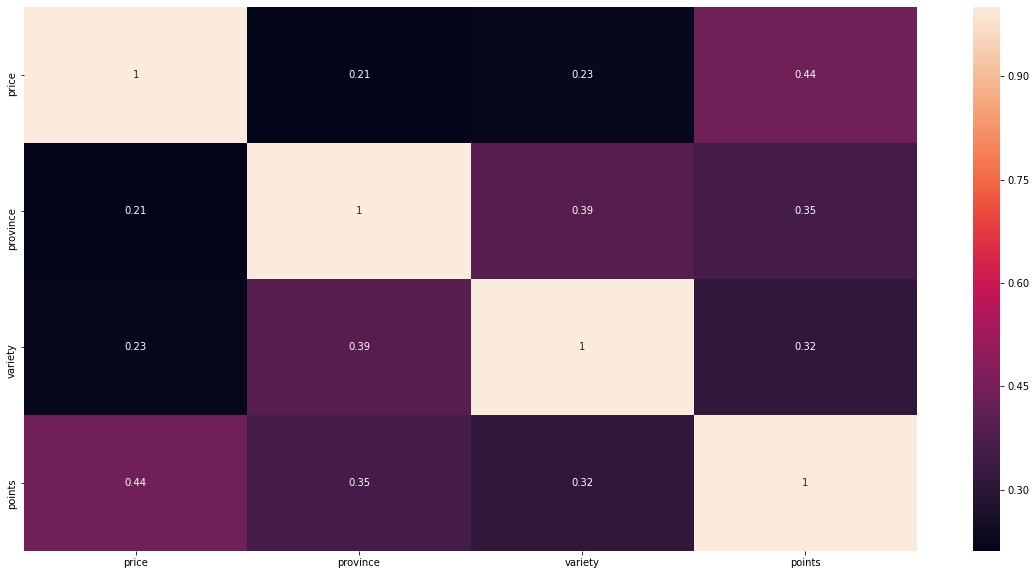

In [48]:
df_merge = pd.DataFrame(X).join(y).drop(columns=["id"], axis=1)
# Plot Correlation with Heatmap
plt.figure(figsize=(20,10))
sns.heatmap(df_merge.corr(),annot=True)
plt.show()

<span style="font-size:0.7cm;font-family:cursive;"> 2. 切分資料集</span><br>

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                        test_size = 0.3, random_state = 123) 

<span style="font-size:0.7cm;font-family:cursive;"> 3. 查看各自的維度</span><br>

In [15]:
# X 訓練資料集維度
X_train.shape

(105651, 4)

In [16]:
# y 訓練資料集維度
y_train.shape

(105651,)

In [17]:
# X 測試資料集維度
X_test.shape

(45279, 4)

<span style="font-size:1cm; line-height: 2cm; font-family:cursive;">四 、 資料處理與轉換</span><span style="font-size:0.7cm; line-height: 2cm; font-family:cursive;"> - 將UID拿出來</span><br>

In [18]:
# 保留UID  做推薦清單時需要將uid放回去 找到推薦人
train_uid = X_train['id']
test_uid = X_test['id']

In [19]:
# 刪除UID 流水號
# del 就是直接刪除，同drop(columns = '欄位')的效果
del X_train['id']
#X_train['UID']
del X_test['id']

In [20]:
# 訓練資料集的X 資料清理checklist
# 1. id是否刪除
# 2. Dtype是否都是數值變數
# 3. y變數是否已經被移除
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105651 entries, 116278 to 15725
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   price     105651 non-null  float64
 1   province  105651 non-null  float64
 2   variety   105651 non-null  float64
dtypes: float64(3)
memory usage: 3.2 MB


<span style="font-size:1cm; line-height: 2cm; font-family:cursive;">五 、  多重線性迴歸</span>

<span style="font-size:0.7cm;font-family:cursive;"> 1. 命名模型物件</span><br>

In [21]:
from sklearn.linear_model import LinearRegression
ml_regressor = LinearRegression()

<span style="font-size:0.7cm;font-family:cursive;"> 2. Feature Scaling</span><br>

In [22]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_logistic = sc.fit_transform(X_train)
X_test_logistic = sc.transform(X_test)


<span style="font-size:0.7cm;font-family:cursive;"> 3. 進行訓練</span><br>

In [23]:

ml_regressor.fit(X_train_logistic, y_train)

LinearRegression()

<span style="font-size:0.7cm;font-family:cursive;"> 4. 預測</span><br>

In [24]:
ml_pred = ml_regressor.predict(X_test)
from sklearn.metrics import r2_score
ml_score = r2_score(y_test, ml_pred)
print("R^2 = {:.3f} ".format(ml_score))
print(ml_score)

R^2 = -2099.352 
-2099.3517269156646


c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but LinearRegression was fitted without feature names



In [25]:
import numpy as np

from sklearn.metrics import mean_absolute_percentage_error
import math

MSE = np.square(np.subtract(y_test,ml_pred)).mean() 
ml_rmse = math.sqrt(MSE)
print("多重線性迴歸 Root Mean Square Error:", ml_rmse)

ml_mape = mean_absolute_percentage_error(y_test, ml_pred)
print("多重線性迴歸 MAPE:", ml_mape)


多重線性迴歸 Root Mean Square Error: 147.49149602453323
多重線性迴歸 MAPE: 1.6164293570917192


<span style="font-size:1cm; line-height: 2cm; font-family:cursive;"> 六、 隨機森林 </span>

In [26]:
# 隨機森林
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
rf_regressor.fit(X_train_logistic, y_train)

rf_pred = rf_regressor.predict(X_test)


c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but RandomForestRegressor was fitted without feature names



In [27]:
rf_score = r2_score(y_test, rf_pred)
print("R^2 = {:.3f} ".format(rf_score))
print(rf_score)

R^2 = -6.310 
-6.310097588331263


In [28]:
#rf_pred # 隨機森林
MSE = np.square(np.subtract(y_test,rf_pred)).mean() 
rf_rmse = math.sqrt(MSE)
print("隨機森林 Root Mean Square Error:", rf_rmse)


rf_mape = mean_absolute_percentage_error(y_test, rf_pred)
print("隨機森林 MAPE:", rf_mape)


隨機森林 Root Mean Square Error: 8.701268177136745
隨機森林 MAPE: 0.09428768949138816


<span style="font-size:1cm; line-height: 2cm; font-family:cursive;"> 七、 決策樹 </span>

In [29]:
# 決策樹
from sklearn.tree import DecisionTreeRegressor
dt_regressor = DecisionTreeRegressor(random_state = 0)
dt_regressor.fit(X_train_logistic, y_train)

dt_pred = dt_regressor.predict(X_test)


c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names



In [30]:
dt_score = r2_score(y_test, dt_pred)
print("R^2 = {:.3f} ".format(dt_score))
print(dt_score)

R^2 = -4.121 
-4.1212870890809095


In [31]:
#dt_pred # 決策樹
MSE = np.square(np.subtract(y_test,dt_pred )).mean() 
dt_rmse = math.sqrt(MSE)
print("決策樹 Root Mean Square Error:", dt_rmse)


dt_mape = mean_absolute_percentage_error(y_test, rf_pred)
print("決策樹 MAPE:", dt_mape)

決策樹 Root Mean Square Error: 7.283003652329337
決策樹 MAPE: 0.09428768949138816


In [32]:
# 將成效評估後的成果形塑如附檔範例，eval範例.png的模樣，並存成「模型比較.csv」
import pandas as pd
model_result = {'模型': ['多重線性回歸', '隨機森林', '決策樹'],
                'RMSE':[ml_rmse, rf_rmse, dt_rmse],
                'MAPE':[ml_mape, rf_mape, dt_mape]}
    
model_df = pd.DataFrame(model_result)

print(model_df)

model_df.to_csv('模型比較.csv',  encoding = 'utf-8')


       模型        RMSE      MAPE
0  多重線性回歸  147.491496  1.616429
1    隨機森林    8.701268  0.094288
2     決策樹    7.283004  0.094288


c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning:

Glyph 22810 missing from current font.

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning:

Glyph 37325 missing from current font.

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning:

Glyph 32218 missing from current font.

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning:

Glyph 24615 missing from current font.

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning:

Glyph 22238 missing from current font.

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning:

Glyph 27512 missing from current

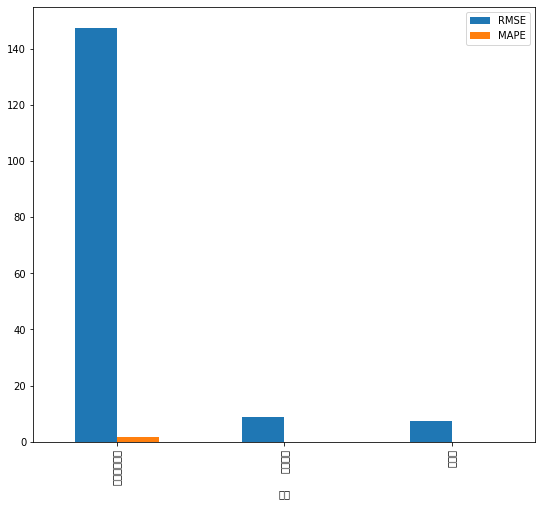

In [33]:
# 問題：請將「模型比較」的dataframe套入plotly，繪製看似如「繪圖範例.png」的html檔案
# 10分
import plotly.express as px
fig = px.histogram(model_df, x = '模型', y = ['RMSE', 'MAPE'])
fig.show()
fig.write_html("./繪圖範例.png.html")
fig.write_image("./繪圖範例.png.jpeg")

import pandas as pd 
import matplotlib.pyplot as plt 
df=pd.DataFrame(model_df,columns=['模型','RMSE', 'MAPE'])
df.plot(x='模型', y=['RMSE', 'MAPE'], kind="bar",figsize=(9,8))
plt.show()